In [ ]:
import yfinance as yf
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string


apple_stock = yf.download('AAPL', start='2019-12-20', end='2024-02-10')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[*********************100%%**********************]  1 of 1 completed


In [ ]:
full_date_range = pd.date_range(start=apple_stock.index.min(), end=apple_stock.index.max())
closed_market_days = full_date_range.difference(apple_stock.index)

In [ ]:
!pip install transformers

In [ ]:
df = pd.read_csv('apple_total.csv')

def clean_text(text):
    """ Lowercase, remove punctuation, and stopwords """
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply the cleaning function to your headlines
df['cleaned_title'] = df['title'].apply(clean_text)

In [ ]:
from transformers import pipeline
df_bert = df
df_finbert = df
classifier = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')
def get_sentiment(text):
    result = classifier(text)
    return result[0]['label'], result[0]['score']

# Apply sentiment analysis
df_bert['sentiment'], df_bert['sentiment_score'] = zip(*df_bert['cleaned_title'].apply(get_sentiment))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import torch

model_name = "yiyanghkust/finbert-tone"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
# Function to get sentiment
def get_sentiment(text):
    result = nlp(text)
    return result[0]['label'], result[0]['score']

# Apply sentiment analysis
df_finbert['sentiment'], df_finbert['sentiment_score'] = zip(*df_finbert['cleaned_title'].apply(get_sentiment))
df_finbert.to_csv('apple_finbert.csv')

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [ ]:
df_bert = pd.read_csv('apple_bert.csv')
df_finbert = pd.read_csv('apple_finbert.csv')

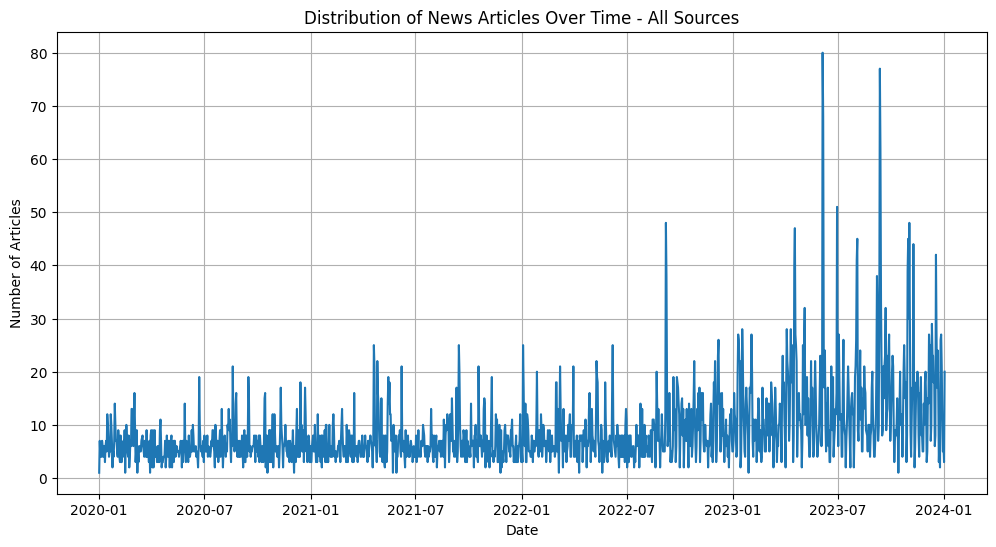

Missing Dates:
DatetimeIndex(['2020-03-01', '2020-03-15', '2020-10-31', '2023-08-20'], dtype='datetime64[ns]', freq=None)


In [ ]:
import matplotlib.pyplot as plt

df_bert['published'] = pd.to_datetime(df_bert['published'], format='%a, %d %b %Y %H:%M:%S GMT')

articles_per_day = df_bert['published'].dt.date.value_counts().sort_index()

plt.figure(figsize=(12, 6))
articles_per_day.plot(kind='line')
plt.title('Distribution of News Articles Over Time - All Sources')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

# Checking for Missing Dates
full_date_range = pd.date_range(start=articles_per_day.index.min(), end=articles_per_day.index.max())
missing_dates = full_date_range.difference(pd.to_datetime(articles_per_day.index))

print("Missing Dates:")
print(missing_dates)


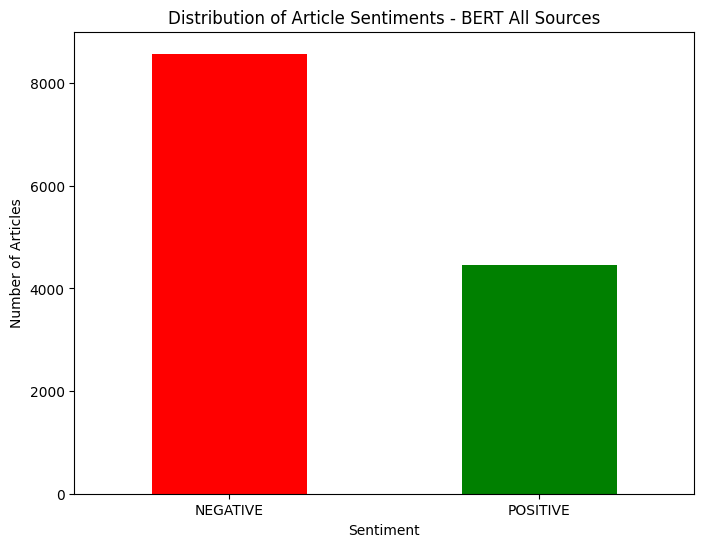

In [ ]:
sentiment_counts = df_bert['sentiment'].value_counts()

# Plotting the sentiment counts
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['red', 'green', 'gray'])
plt.title('Distribution of Article Sentiments - BERT All Sources')
plt.xlabel('Sentiment')
plt.ylabel('Number of Articles')
plt.xticks(rotation=0)
plt.show()

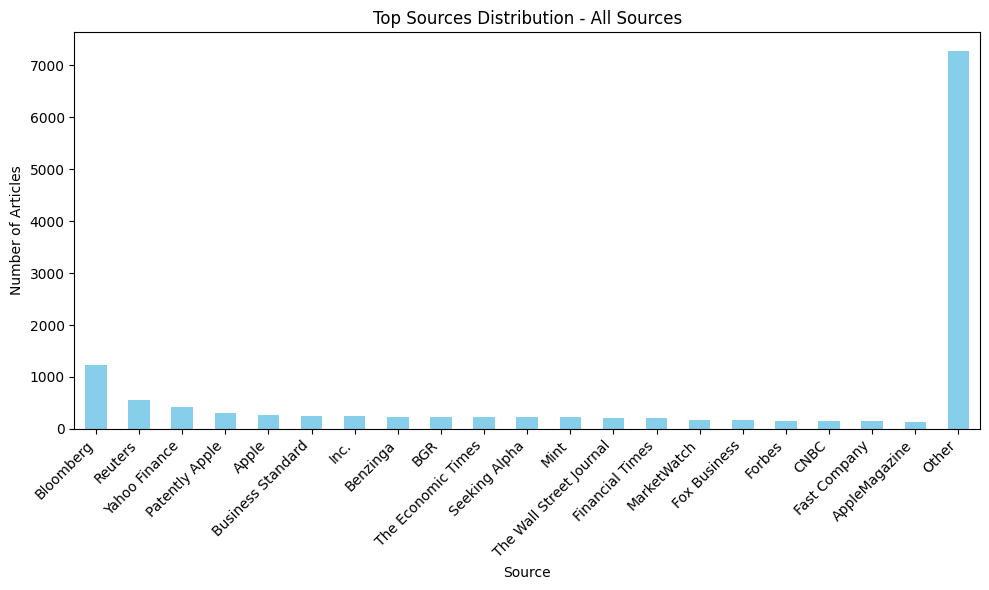

In [ ]:
source_counts = df_bert['source'].value_counts()
top_n = 20
top_sources = source_counts.nlargest(top_n)
top_sources['Other'] = source_counts[top_n:].sum()

# Plotting the top N sources with 'Other' category
plt.figure(figsize=(10, 6))
top_sources.plot(kind='bar', color='skyblue')
plt.title('Top Sources Distribution - All Sources')
plt.xlabel('Source')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [ ]:
from scipy.stats import chi2_contingency
df_bert['published'] = pd.to_datetime(df_bert['published'], format='%a, %d %b %Y %H:%M:%S GMT')

df_bert['numeric_score'] = df_bert.apply(lambda row: row['sentiment_score'] if row['sentiment'] == 'POSITIVE' else -row['sentiment_score'], axis=1)

def classify_publication_time(row):
    local_publish_date = pd.Timestamp(row['published'].date())
    if local_publish_date in closed_market_days:
        return 'Closed Day'
    else:
        return 'Open Day'

df_bert['market_condition'] = df_bert.apply(classify_publication_time, axis=1)

def find_next_open_day(current_date):
    next_day = pd.Timestamp(current_date) + pd.DateOffset(days=1)
    while next_day in closed_market_days:
        next_day += pd.DateOffset(days=1)
    return next_day

def find_last_open_day(current_date):
    prev_day = pd.Timestamp(current_date) - pd.DateOffset(days=1)  # current_date'i Timestamp'a çevir
    while prev_day in closed_market_days:
        prev_day -= pd.DateOffset(days=1)
    return prev_day

def calculate_impact(row):
    local_publish_date = pd.Timestamp(row['published'].date())
    if row['market_condition'] == 'Open Day':
        prev_open_day = find_last_open_day(local_publish_date)
        impact_value = apple_stock.loc[local_publish_date, 'Close'] - apple_stock.loc[prev_open_day, 'Close']
        impact_group = f'{local_publish_date} Close - {prev_open_day} Close'
    elif row['market_condition'] == 'Closed Day':
        next_open_day = find_next_open_day(local_publish_date)
        last_close_day = find_last_open_day(local_publish_date)
        impact_value = apple_stock.loc[next_open_day, 'Close'] - apple_stock.loc[last_close_day, 'Close']
        impact_group = f'{next_open_day} Close - {last_close_day} Close'
    return impact_value, impact_group

results = df_bert.apply(calculate_impact, axis=1, result_type='expand')
df_bert['impact'] = results[0]
df_bert['impact_group'] = results[1]

grouped_data = df_bert.groupby('impact_group').agg({
    'numeric_score': 'mean',
    'impact': 'mean'
}).reset_index()

# Continous vs Continous
# Lineer Correlation
correlation1 = grouped_data['numeric_score'].corr(grouped_data['impact'])
print("Bütün sourcelar ile BERT")
print("Bugün yayınlanan için bugünün close'u - bir önceki günün close'u")
print("Korelasyon Katsayısı:", correlation1)

def impact_type(row):
  if row['impact'] > 0:
    return 'Positive'
  elif row['impact'] == 0:
    return 'Neutral'
  else:
    return 'Negative'

def sentiment_type(row):
  if row['numeric_score'] > 0:
    return 'POSITIVE'
  elif row['numeric_score'] == 0:
    return 'NEUTRAL'
  else:
    return 'NEGATIVE'

grouped_data['numeric_score_type'] = grouped_data.apply(sentiment_type, axis=1)
grouped_data['impact_type'] = grouped_data.apply(impact_type, axis=1)

# Continous vs Categorical
# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('numeric_score ~ C(impact_type)', data=grouped_data).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print("ANOVA:", anova_result)

# Categorical vs Categorical
# Chi-Square Test
contingency_table1 = pd.crosstab(grouped_data['numeric_score_type'], grouped_data['impact_type'])
chi2, p, dof, expected = chi2_contingency(contingency_table1)
print("Chi-square test:", chi2)
print("p-value:", p)


Bütün sourcelar ile BERT
Bugün yayınlanan için bugünün close'u - bir önceki günün close'u
Korelasyon Katsayısı: -0.01756569135281304
ANOVA:                     sum_sq      df        F    PR(>F)
C(impact_type)    0.093468     2.0  0.39607  0.673065
Residual        118.466341  1004.0      NaN       NaN
Chi-square test: 0.8886431188515608
p-value: 0.6412591847352974


In [ ]:
df_bert_source_limited = df_bert
news_outlets = [
    "Yahoo Finance", "The Motley Fool", "Forbes", "Seeking Alpha"," Barron's","CNBC",
    "Reuters", "MarketWatch", "Bloomberg", "Investor's Business Daily", "TheStreet", "The Wall Street Journal",
    "Markets Insider", "Business Insider", "Financial Times", "Investopedia", "Nasdaq", "Fortune", "The Economic Times", "Fox Business"
]

df_bert_source_limited = df_bert[df_bert['source'].isin(news_outlets)].copy()
df_bert_source_limited.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4151 entries, 0 to 13028
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        4151 non-null   int64         
 1   title             4151 non-null   object        
 2   published         4151 non-null   datetime64[ns]
 3   source            4151 non-null   object        
 4   link              4151 non-null   object        
 5   published_date    4151 non-null   object        
 6   cleaned_title     4151 non-null   object        
 7   sentiment         4151 non-null   object        
 8   sentiment_score   4151 non-null   float64       
 9   numeric_score     4151 non-null   float64       
 10  market_condition  4151 non-null   object        
 11  impact            4151 non-null   float64       
 12  impact_group      4151 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(8)
memory usage: 454.0+ KB


In [ ]:
from scipy.stats import chi2_contingency

df_bert_source_limited['numeric_score'] = df_bert_source_limited.apply(lambda row: row['sentiment_score'] if row['sentiment'] == 'POSITIVE' else -row['sentiment_score'], axis=1)

def classify_publication_time(row):
    local_publish_date = pd.Timestamp(row['published'].date())
    if local_publish_date in closed_market_days:
        return 'Closed Day'
    else:
        return 'Open Day'

df_bert_source_limited['market_condition'] = df_bert_source_limited.apply(classify_publication_time, axis=1)

def find_next_open_day(current_date):
    next_day = pd.Timestamp(current_date) + pd.DateOffset(days=1)
    while next_day in closed_market_days:
        next_day += pd.DateOffset(days=1)
    return next_day

def find_last_open_day(current_date):
    prev_day = pd.Timestamp(current_date) - pd.DateOffset(days=1)  # current_date'i Timestamp'a çevir
    while prev_day in closed_market_days:
        prev_day -= pd.DateOffset(days=1)
    return prev_day

def calculate_impact(row):
    local_publish_date = pd.Timestamp(row['published'].date())
    if row['market_condition'] == 'Open Day':
        prev_open_day = find_last_open_day(local_publish_date)
        impact_value = apple_stock.loc[local_publish_date, 'Close'] - apple_stock.loc[prev_open_day, 'Close']
        impact_group = f'{local_publish_date} Close - {prev_open_day} Close'
    elif row['market_condition'] == 'Closed Day':
        next_open_day = find_next_open_day(local_publish_date)
        last_close_day = find_last_open_day(local_publish_date)
        impact_value = apple_stock.loc[next_open_day, 'Close'] - apple_stock.loc[last_close_day, 'Close']
        impact_group = f'{next_open_day} Close - {last_close_day} Close'
    return impact_value, impact_group

results = df_bert_source_limited.apply(calculate_impact, axis=1, result_type='expand')
df_bert_source_limited['impact'] = results[0]
df_bert_source_limited['impact_group'] = results[1]

grouped_data = df_bert_source_limited.groupby('impact_group').agg({
    'numeric_score': 'mean',
    'impact': 'mean'
}).reset_index()

# Continous vs Continous
# Lineer Correlation
correlation1 = grouped_data['numeric_score'].corr(grouped_data['impact'])
print("20 source ile BERT")
print("Bugün yayınlanan için bugünün close'u - bir önceki günün close'u")
print("Korelasyon Katsayısı:", correlation1)

def impact_type(row):
  if row['impact'] > 0:
    return 'Positive'
  elif row['impact'] == 0:
    return 'Neutral'
  else:
    return 'Negative'

def sentiment_type(row):
  if row['numeric_score'] > 0:
    return 'POSITIVE'
  elif row['numeric_score'] == 0:
    return 'NEUTRAL'
  else:
    return 'NEGATIVE'

grouped_data['numeric_score_type'] = grouped_data.apply(sentiment_type, axis=1)
grouped_data['impact_type'] = grouped_data.apply(impact_type, axis=1)

# Continous vs Categorical
# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('numeric_score ~ C(impact_type)', data=grouped_data).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print("ANOVA:", anova_result)

# Categorical vs Categorical
# Chi-Square Test
contingency_table1 = pd.crosstab(grouped_data['numeric_score_type'], grouped_data['impact_type'])
chi2, p, dof, expected = chi2_contingency(contingency_table1)
print("Chi-square test:", chi2)
print("p-value:", p)


20 source ile BERT
Bugün yayınlanan için bugünün close'u - bir önceki günün close'u
Korelasyon Katsayısı: -0.04321379970734618
ANOVA:                     sum_sq     df         F    PR(>F)
C(impact_type)    1.136842    2.0  2.036278  0.131091
Residual        261.560865  937.0       NaN       NaN
Chi-square test: 6.318522108244274
p-value: 0.042457102992949025


In [ ]:
import numpy as np
from scipy.stats import chi2_contingency

# Önceki Chi-square testinizden elde edilen değerleri kullanalım
dof = min((contingency_table1.shape[0] - 1), (contingency_table1.shape[1] - 1))

# Cramer's V katsayısını hesaplama
n = contingency_table1.sum().sum()  # Toplam gözlem sayısı
cramer_v = np.sqrt(chi2 / (n * dof))

print("Cramer's V Katsayısı:", cramer_v)

# Kondisyonel olasılık hesaplamaları için
conditional_probabilities = contingency_table1.div(contingency_table1.sum(axis=1), axis=0)
print("\nKondisyonel Olasılıklar:\n", conditional_probabilities)


Cramer's V Katsayısı: 0.0819867796052943

Kondisyonel Olasılıklar:
 impact_type         Negative   Neutral  Positive
numeric_score_type                              
NEGATIVE            0.467181  0.001287  0.531532
POSITIVE            0.509202  0.012270  0.478528


FinBERT

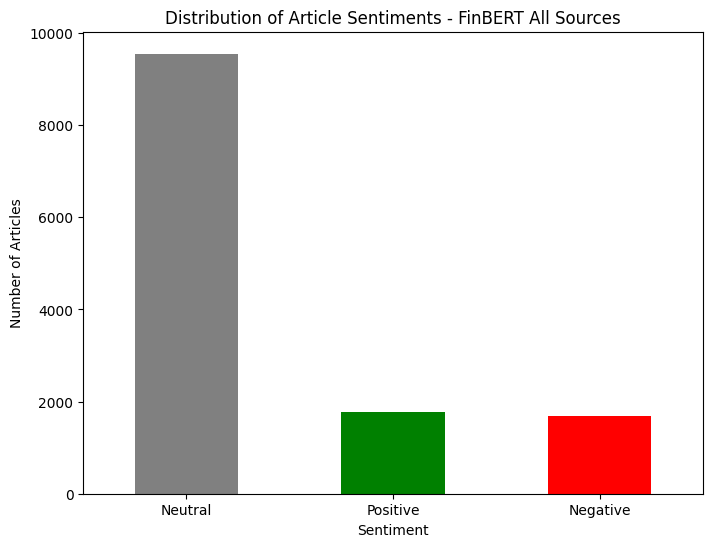

In [ ]:
sentiment_counts = df_finbert['sentiment'].value_counts()

# Plotting the sentiment counts
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['gray', 'green', 'red'])
plt.title('Distribution of Article Sentiments - FinBERT All Sources')
plt.xlabel('Sentiment')
plt.ylabel('Number of Articles')
plt.xticks(rotation=0)
plt.show()

In [ ]:
from scipy.stats import chi2_contingency

df_finbert['published_date'] = pd.to_datetime(df_finbert['published_date'], format='%Y-%m-%d %H:%M:%S')

def numeric_score(row):
  if row['sentiment'] == 'Positive':
    return row['sentiment_score']
  elif row['sentiment'] == 'Negative':
    return -row['sentiment_score']
  else:
    return 0
df_finbert['numeric_score'] = df_finbert.apply(numeric_score, axis=1)

def classify_publication_time(row):
    local_publish_date = pd.Timestamp(row['published_date'].date())
    if local_publish_date in closed_market_days:
        return 'Closed Day'
    else:
        return 'Open Day'

df_finbert['market_condition'] = df_finbert.apply(classify_publication_time, axis=1)

def find_next_open_day(current_date):
    next_day = pd.Timestamp(current_date) + pd.DateOffset(days=1)
    while next_day in closed_market_days:
        next_day += pd.DateOffset(days=1)
    return next_day

def find_last_open_day(current_date):
    prev_day = pd.Timestamp(current_date) - pd.DateOffset(days=1)  # current_date'i Timestamp'a çevir
    while prev_day in closed_market_days:
        prev_day -= pd.DateOffset(days=1)
    return prev_day

def calculate_impact(row):
    local_publish_date = pd.Timestamp(row['published_date'].date())
    if row['market_condition'] == 'Open Day':
        prev_open_day = find_last_open_day(local_publish_date)
        impact_value = apple_stock.loc[local_publish_date, 'Close'] - apple_stock.loc[prev_open_day, 'Close']
        impact_group = f'{local_publish_date} Close - {prev_open_day} Close'
    elif row['market_condition'] == 'Closed Day':
        next_open_day = find_next_open_day(local_publish_date)
        last_close_day = find_last_open_day(local_publish_date)
        impact_value = apple_stock.loc[next_open_day, 'Close'] - apple_stock.loc[last_close_day, 'Close']
        impact_group = f'{next_open_day} Close - {last_close_day} Close'
    return impact_value, impact_group

results = df_finbert.apply(calculate_impact, axis=1, result_type='expand')
df_finbert['impact'] = results[0]
df_finbert['impact_group'] = results[1]

grouped_data = df_finbert.groupby('impact_group').agg({
    'numeric_score': 'mean',
    'impact': 'mean'
}).reset_index()

# Continous vs Continous
# Lineer Correlation
correlation1 = grouped_data['numeric_score'].corr(grouped_data['impact'])
print("Bütün sourcelar ile FinBERT")
print("Bugün yayınlanan için bugünün close'u - bir önceki günün close'u")
print("Korelasyon Katsayısı:", correlation1)

def impact_type(row):
  if row['impact'] > 0:
    return 'Positive'
  elif row['impact'] == 0:
    return 'Neutral'
  else:
    return 'Negative'

def sentiment_type(row):
  if row['numeric_score'] > 0:
    return 'POSITIVE'
  elif row['numeric_score'] == 0:
    return 'NEUTRAL'
  else:
    return 'NEGATIVE'

grouped_data['numeric_score_type'] = grouped_data.apply(sentiment_type, axis=1)
grouped_data['impact_type'] = grouped_data.apply(impact_type, axis=1)

# Continous vs Categorical
# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('numeric_score ~ C(impact_type)', data=grouped_data).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print("ANOVA:", anova_result)

# Categorical vs Categorical
# Chi-Square Test
contingency_table1 = pd.crosstab(grouped_data['numeric_score_type'], grouped_data['impact_type'])
chi2, p, dof, expected = chi2_contingency(contingency_table1)
print("Chi-square test:", chi2)
print("p-value:", p)


Bütün sourcelar ile FinBERT
Bugün yayınlanan için bugünün close'u - bir önceki günün close'u
Korelasyon Katsayısı: 0.07983011328679569
ANOVA:                    sum_sq      df      F    PR(>F)
C(impact_type)   0.040023     2.0  0.596  0.551206
Residual        33.710598  1004.0    NaN       NaN
Chi-square test: 16.45766443657882
p-value: 0.0024626932816016883


In [ ]:
import numpy as np
from scipy.stats import chi2_contingency

# Önceki Chi-square testinizden elde edilen değerleri kullanalım
dof = min((contingency_table1.shape[0] - 1), (contingency_table1.shape[1] - 1))

# Cramer's V katsayısını hesaplama
n = contingency_table1.sum().sum()  # Toplam gözlem sayısı
cramer_v = np.sqrt(chi2 / (n * dof))

print("Cramer's V Katsayısı:", cramer_v)

# Kondisyonel olasılık hesaplamaları için
conditional_probabilities = contingency_table1.div(contingency_table1.sum(axis=1), axis=0)
print("\nKondisyonel Olasılıklar:\n", conditional_probabilities)


Cramer's V Katsayısı: 0.09039707297623477

Kondisyonel Olasılıklar:
 impact_type         Negative   Neutral  Positive
numeric_score_type                              
NEGATIVE            0.497596  0.002404  0.500000
NEUTRAL             0.516484  0.021978  0.461538
POSITIVE            0.444000  0.000000  0.556000


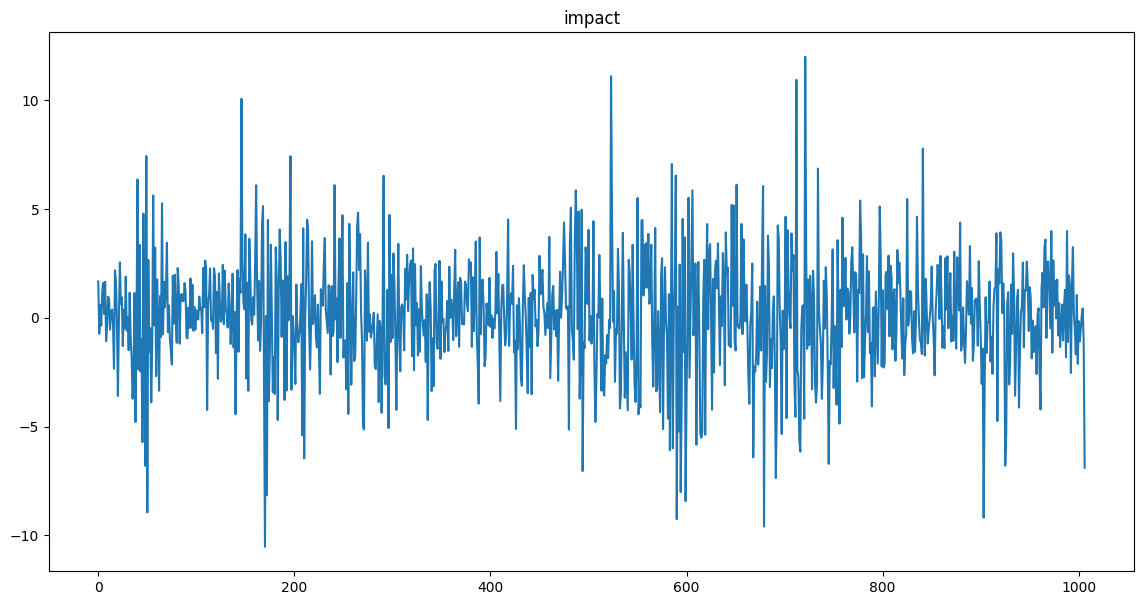

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(grouped_data['impact'])
plt.title('impact')
plt.show()

finBERT threshold

In [ ]:
from scipy.stats import chi2_contingency

df_finbert['published_date'] = pd.to_datetime(df_finbert['published_date'], format='%Y-%m-%d %H:%M:%S')

def numeric_score(row):
  if row['sentiment'] == 'Positive':
    return row['sentiment_score']
  elif row['sentiment'] == 'Negative':
    return -row['sentiment_score']
  else:
    return 0
df_finbert['numeric_score'] = df_finbert.apply(numeric_score, axis=1)

def classify_publication_time(row):
    local_publish_date = pd.Timestamp(row['published_date'].date())
    if local_publish_date in closed_market_days:
        return 'Closed Day'
    else:
        return 'Open Day'

df_finbert['market_condition'] = df_finbert.apply(classify_publication_time, axis=1)

def find_next_open_day(current_date):
    next_day = pd.Timestamp(current_date) + pd.DateOffset(days=1)
    while next_day in closed_market_days:
        next_day += pd.DateOffset(days=1)
    return next_day

def find_last_open_day(current_date):
    prev_day = pd.Timestamp(current_date) - pd.DateOffset(days=1)  # current_date'i Timestamp'a çevir
    while prev_day in closed_market_days:
        prev_day -= pd.DateOffset(days=1)
    return prev_day

def calculate_impact(row):
    local_publish_date = pd.Timestamp(row['published_date'].date())
    if row['market_condition'] == 'Open Day':
        prev_open_day = find_last_open_day(local_publish_date)
        impact_value = apple_stock.loc[local_publish_date, 'Close'] - apple_stock.loc[prev_open_day, 'Close']
        impact_group = f'{local_publish_date} Close - {prev_open_day} Close'
    elif row['market_condition'] == 'Closed Day':
        next_open_day = find_next_open_day(local_publish_date)
        last_close_day = find_last_open_day(local_publish_date)
        impact_value = apple_stock.loc[next_open_day, 'Close'] - apple_stock.loc[last_close_day, 'Close']
        impact_group = f'{next_open_day} Close - {last_close_day} Close'
    return impact_value, impact_group

results = df_finbert.apply(calculate_impact, axis=1, result_type='expand')
df_finbert['impact'] = results[0]
df_finbert['impact_group'] = results[1]

grouped_data = df_finbert.groupby('impact_group').agg({
    'numeric_score': 'mean',
    'impact': 'mean'
}).reset_index()

# Continous vs Continous
# Lineer Correlation
correlation1 = grouped_data['numeric_score'].corr(grouped_data['impact'])
print("Bütün sourcelar + threshold FinBERT")
print("Bugün yayınlanan için bugünün close'u - bir önceki günün close'u")
print("Korelasyon Katsayısı:", correlation1)

def adjust_impact_type(row, threshold):
    if abs(row['impact']) < threshold:
        return 'Neutral'
    elif row['impact'] > 0:
        return 'Positive'
    else:
        return 'Negative'

def sentiment_type(row):
  if row['numeric_score'] > 0:
    return 'POSITIVE'
  elif row['numeric_score'] == 0:
    return 'NEUTRAL'
  else:
    return 'NEGATIVE'

abs_impact = abs(grouped_data['impact'])

# Ortalamasını ve standart sapmasını hesapla
mean_impact = abs_impact.mean()
std_dev_impact = abs_impact.std()

# Threshold değeri belirle
threshold = mean_impact + 2 * std_dev_impact
print(f"Threshold değeri: {threshold}")
grouped_data['numeric_score_type'] = grouped_data.apply(sentiment_type, axis=1)
grouped_data['impact_type'] = grouped_data.apply(lambda row: adjust_impact_type(row, threshold), axis=1)
# Continous vs Categorical
# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('numeric_score ~ C(impact_type)', data=grouped_data).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print("ANOVA:", anova_result)

# Categorical vs Categorical
# Chi-Square Test
contingency_table1 = pd.crosstab(grouped_data['numeric_score_type'], grouped_data['impact_type'])
chi2, p, dof, expected = chi2_contingency(contingency_table1)
print("Chi-square test:", chi2)
print("p-value:", p)
print("-----")


Bütün sourcelar + threshold FinBERT
Bugün yayınlanan için bugünün close'u - bir önceki günün close'u
Korelasyon Katsayısı: 0.07983011328679569
Threshold değeri: 5.520404847252724
ANOVA:                    sum_sq      df         F   PR(>F)
C(impact_type)   0.076309     2.0  1.137569  0.32101
Residual        33.674313  1004.0       NaN      NaN
Chi-square test: 10.258157287071109
p-value: 0.03629649104781954
-----


In [ ]:
import numpy as np
from scipy.stats import chi2_contingency

# Önceki Chi-square testinizden elde edilen değerleri kullanalım
dof = min((contingency_table1.shape[0] - 1), (contingency_table1.shape[1] - 1))

# Cramer's V katsayısını hesaplama
n = contingency_table1.sum().sum()  # Toplam gözlem sayısı
cramer_v = np.sqrt(chi2 / (n * dof))

print("Cramer's V Katsayısı:", cramer_v)

# Kondisyonel olasılık hesaplamaları için
conditional_probabilities = contingency_table1.div(contingency_table1.sum(axis=1), axis=0)
print("\nKondisyonel Olasılıklar:\n", conditional_probabilities)


Cramer's V Katsayısı: 0.07136823292501837

Kondisyonel Olasılıklar:
 impact_type         Negative   Neutral  Positive
numeric_score_type                              
NEGATIVE            0.038462  0.939904  0.021635
NEUTRAL             0.000000  0.989011  0.010989
POSITIVE            0.012000  0.970000  0.018000


In [ ]:
from scipy.stats import chi2_contingency

df_finbert['published_date'] = pd.to_datetime(df_finbert['published_date'], format='%Y-%m-%d %H:%M:%S')

def numeric_score(row):
  if row['sentiment'] == 'Positive':
    return row['sentiment_score']
  elif row['sentiment'] == 'Negative':
    return -row['sentiment_score']
  else:
    return 0
df_finbert['numeric_score'] = df_finbert.apply(numeric_score, axis=1)

def classify_publication_time(row):
    local_publish_date = pd.Timestamp(row['published_date'].date())
    if local_publish_date in closed_market_days:
        return 'Closed Day'
    else:
        return 'Open Day'

df_finbert['market_condition'] = df_finbert.apply(classify_publication_time, axis=1)

def find_next_open_day(current_date):
    next_day = pd.Timestamp(current_date) + pd.DateOffset(days=1)
    while next_day in closed_market_days:
        next_day += pd.DateOffset(days=1)
    return next_day

def find_last_open_day(current_date):
    prev_day = pd.Timestamp(current_date) - pd.DateOffset(days=1)  # current_date'i Timestamp'a çevir
    while prev_day in closed_market_days:
        prev_day -= pd.DateOffset(days=1)
    return prev_day

def calculate_impact(row):
    local_publish_date = pd.Timestamp(row['published_date'].date())
    if row['market_condition'] == 'Open Day':
        prev_open_day = find_last_open_day(local_publish_date)
        impact_value = apple_stock.loc[local_publish_date, 'Close'] - apple_stock.loc[prev_open_day, 'Close']
        impact_group = f'{local_publish_date} Close - {prev_open_day} Close'
    elif row['market_condition'] == 'Closed Day':
        next_open_day = find_next_open_day(local_publish_date)
        last_close_day = find_last_open_day(local_publish_date)
        impact_value = apple_stock.loc[next_open_day, 'Close'] - apple_stock.loc[last_close_day, 'Close']
        impact_group = f'{next_open_day} Close - {last_close_day} Close'
    return impact_value, impact_group

results = df_finbert.apply(calculate_impact, axis=1, result_type='expand')
df_finbert['impact'] = results[0]
df_finbert['impact_group'] = results[1]

grouped_data = df_finbert.groupby('impact_group').agg({
    'numeric_score': 'mean',
    'impact': 'mean'
}).reset_index()

# Continous vs Continous
# Lineer Correlation
correlation1 = grouped_data['numeric_score'].corr(grouped_data['impact'])
print("Bütün sourcelar + threshold FinBERT")
print("Bugün yayınlanan için bugünün close'u - bir önceki günün close'u")
print("Korelasyon Katsayısı:", correlation1)

def adjust_impact_type(row, threshold):
    if abs(row['impact']) < threshold:
        return 'Neutral'
    elif row['impact'] > 0:
        return 'Positive'
    else:
        return 'Negative'

def sentiment_type(row):
  if row['numeric_score'] > 0:
    return 'POSITIVE'
  elif row['numeric_score'] == 0:
    return 'NEUTRAL'
  else:
    return 'NEGATIVE'

abs_impact = abs(grouped_data['impact'])

# Ortalamasını ve standart sapmasını hesapla
mean_impact = abs_impact.mean()
std_dev_impact = abs_impact.std()

# Threshold değeri belirle
threshold = 1
print(f"Threshold değeri: {threshold}")
grouped_data['numeric_score_type'] = grouped_data.apply(sentiment_type, axis=1)
grouped_data['impact_type'] = grouped_data.apply(lambda row: adjust_impact_type(row, threshold), axis=1)
# Continous vs Categorical
# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('numeric_score ~ C(impact_type)', data=grouped_data).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print("ANOVA:", anova_result)

# Categorical vs Categorical
# Chi-Square Test
contingency_table1 = pd.crosstab(grouped_data['numeric_score_type'], grouped_data['impact_type'])
chi2, p, dof, expected = chi2_contingency(contingency_table1)
print("Chi-square test:", chi2)
print("p-value:", p)
print("-----")


Bütün sourcelar + threshold FinBERT
Bugün yayınlanan için bugünün close'u - bir önceki günün close'u
Korelasyon Katsayısı: 0.07983011328679569
Threshold değeri: 1
ANOVA:                    sum_sq      df         F    PR(>F)
C(impact_type)   0.228039     2.0  3.414887  0.033263
Residual        33.522582  1004.0       NaN       NaN
Chi-square test: 13.25891701857415
p-value: 0.01007758493176632
-----


In [ ]:
import numpy as np
from scipy.stats import chi2_contingency

# Önceki Chi-square testinizden elde edilen değerleri kullanalım
dof = min((contingency_table1.shape[0] - 1), (contingency_table1.shape[1] - 1))

# Cramer's V katsayısını hesaplama
n = contingency_table1.sum().sum()  # Toplam gözlem sayısı
cramer_v = np.sqrt(chi2 / (n * dof))

print("Cramer's V Katsayısı:", cramer_v)

# Kondisyonel olasılık hesaplamaları için
conditional_probabilities = contingency_table1.div(contingency_table1.sum(axis=1), axis=0)
print("\nKondisyonel Olasılıklar:\n", conditional_probabilities)


Cramer's V Katsayısı: 0.08113799902075128

Kondisyonel Olasılıklar:
 impact_type         Negative   Neutral  Positive
numeric_score_type                              
NEGATIVE            0.326923  0.370192  0.302885
NEUTRAL             0.373626  0.340659  0.285714
POSITIVE            0.260000  0.340000  0.400000


finbert- lagged

In [ ]:
def find_next_open_day_(current_date, delay):
    next_day = pd.Timestamp(current_date) + pd.DateOffset(days=delay)
    while next_day in closed_market_days:
        next_day += pd.DateOffset(days=1)
    return next_day

def find_last_open_day_(current_date):
    prev_day = pd.Timestamp(current_date) - pd.DateOffset(days=1)  # current_date'i Timestamp'a çevir
    while prev_day in closed_market_days:
        prev_day -= pd.DateOffset(days=1)
    return prev_day

def calculate_impact_(row, delay):
    local_publish_date = pd.Timestamp(row['published_date'].date())
    if row['market_condition'] == 'Open Day':
        next_open_day = find_next_open_day_(local_publish_date, delay)
        impact_value = apple_stock.loc[next_open_day, 'Close'] - apple_stock.loc[local_publish_date, 'Close']
        impact_group = f'{next_open_day} Close - {local_publish_date} Close'
    elif row['market_condition'] == 'Closed Day':
        next_open_day = find_next_open_day_(local_publish_date, 1)
        last_close_day = find_last_open_day_(local_publish_date)
        impact_value = apple_stock.loc[next_open_day, 'Close'] - apple_stock.loc[last_close_day, 'Close']
        impact_group = f'{next_open_day} Close - {last_close_day} Close'
    return impact_value, impact_group

def impact_type_(row, x):
  if row[x] > 0:
    return 'Positive'
  elif row[x] == 0:
    return 'Neutral'
  else:
    return 'Negative'

def sentiment_type(row):
  if row['numeric_score'] > 0:
    return 'POSITIVE'
  elif row['numeric_score'] == 0:
    return 'NEUTRAL'
  else:
    return 'NEGATIVE'

for delay in range(1,30):
    results = df_finbert.apply(lambda row: calculate_impact_(row, delay), axis=1, result_type='expand')
    df_finbert[f'impact_in_{delay}_days'] = results[0]
    df_finbert[f'impact_group_in_{delay}_days'] = results[1]
    grouped_data1 = df_finbert.groupby(f'impact_group_in_{delay}_days').agg({
      'numeric_score': 'mean',
      f'impact_in_{delay}_days': 'mean'
    }).reset_index()
    correlation1 = grouped_data1['numeric_score'].corr(grouped_data1[f'impact_in_{delay}_days'])
    print(f"FinBERT - {delay} lag")
    print("Korelasyon Katsayısı:", correlation1)
    grouped_data1['numeric_score_type'] = grouped_data1.apply(sentiment_type, axis=1)
    grouped_data1['impact_type'] = grouped_data1.apply(lambda row:impact_type_(row, f'impact_in_{delay}_days'), axis=1)
    contingency_table1 = pd.crosstab(grouped_data1['numeric_score_type'], grouped_data1['impact_type'])
    chi2, p, dof, expected = chi2_contingency(contingency_table1)
    print("Chi-square test:", chi2)
    print("p-value:", p)
    print("--------")




FinBERT - 1 lag
Korelasyon Katsayısı: 0.048814556834365294
Chi-square test: 0.9266625233745487
p-value: 0.9207048702540097
--------
FinBERT - 2 lag
Korelasyon Katsayısı: 0.03075047755075518
Chi-square test: 1.3912692312002062
p-value: 0.8457110380116313
--------
FinBERT - 3 lag
Korelasyon Katsayısı: 0.026918598650838017
Chi-square test: 2.133291306005308
p-value: 0.7112588735877663
--------
FinBERT - 4 lag
Korelasyon Katsayısı: 0.032180594922298474
Chi-square test: 17.658468138629594
p-value: 0.0014389047344701728
--------
FinBERT - 5 lag
Korelasyon Katsayısı: 0.023978316348737507
Chi-square test: 16.811345440300297
p-value: 0.002103064458427974
--------
FinBERT - 6 lag
Korelasyon Katsayısı: -0.006170464698925959
Chi-square test: 16.446496867391918
p-value: 0.0024749845300067186
--------
FinBERT - 7 lag
Korelasyon Katsayısı: 0.002303694145448662
Chi-square test: 8.473235789488347
p-value: 0.07570265513376506
--------
FinBERT - 8 lag
Korelasyon Katsayısı: 0.005359052320798005
Chi-square

In [ ]:
delay = 6
grouped_data1 = df_finbert.groupby(f'impact_group_in_{delay}_days').agg({
      'numeric_score': 'mean',
      f'impact_in_{delay}_days': 'mean'
}).reset_index()
correlation1 = grouped_data1['numeric_score'].corr(grouped_data1[f'impact_in_{delay}_days'])
print(f"FinBERT - {delay} lag")
print("Korelasyon Katsayısı:", correlation1)
grouped_data1['numeric_score_type'] = grouped_data1.apply(sentiment_type, axis=1)
grouped_data1['impact_type'] = grouped_data1.apply(lambda row:impact_type_(row, f'impact_in_{delay}_days'), axis=1)
contingency_table1 = pd.crosstab(grouped_data1['numeric_score_type'], grouped_data1['impact_type'])
chi2, p, dof, expected = chi2_contingency(contingency_table1)
print("Chi-square test:", chi2)
print("p-value:", p)

FinBERT - 6 lag
Korelasyon Katsayısı: -0.006170464698925959
Chi-square test: 16.446496867391918
p-value: 0.0024749845300067186


In [ ]:
import numpy as np
from scipy.stats import chi2_contingency

# Önceki Chi-square testinizden elde edilen değerleri kullanalım
dof = min((contingency_table1.shape[0] - 1), (contingency_table1.shape[1] - 1))

# Cramer's V katsayısını hesaplama
n = contingency_table1.sum().sum()  # Toplam gözlem sayısı
cramer_v = np.sqrt(chi2 / (n * dof))

print("Cramer's V Katsayısı:", cramer_v)

# Kondisyonel olasılık hesaplamaları için
conditional_probabilities = contingency_table1.div(contingency_table1.sum(axis=1), axis=0)
print("\nKondisyonel Olasılıklar:\n", conditional_probabilities)


Cramer's V Katsayısı: 0.08203252934327308

Kondisyonel Olasılıklar:
 impact_type         Negative   Neutral  Positive
numeric_score_type                              
NEGATIVE            0.445312  0.000000  0.554688
NEUTRAL             0.428571  0.015038  0.556391
POSITIVE            0.443674  0.000000  0.556326


bert lagged analysis

In [ ]:
def find_next_open_day_(current_date, delay):
    next_day = pd.Timestamp(current_date) + pd.DateOffset(days=delay)
    while next_day in closed_market_days:
        next_day += pd.DateOffset(days=1)
    return next_day

def find_last_open_day_(current_date):
    prev_day = pd.Timestamp(current_date) - pd.DateOffset(days=1)  # current_date'i Timestamp'a çevir
    while prev_day in closed_market_days:
        prev_day -= pd.DateOffset(days=1)
    return prev_day

def calculate_impact_(row, delay):
    local_publish_date = pd.Timestamp(row['published'].date())
    if row['market_condition'] == 'Open Day':
        next_open_day = find_next_open_day_(local_publish_date, delay)
        impact_value = apple_stock.loc[next_open_day, 'Close'] - apple_stock.loc[local_publish_date, 'Close']
        impact_group = f'{next_open_day} Close - {local_publish_date} Close'
    elif row['market_condition'] == 'Closed Day':
        next_open_day = find_next_open_day_(local_publish_date, 1)
        last_close_day = find_last_open_day_(local_publish_date)
        impact_value = apple_stock.loc[next_open_day, 'Close'] - apple_stock.loc[last_close_day, 'Close']
        impact_group = f'{next_open_day} Close - {last_close_day} Close'
    return impact_value, impact_group

for delay in range(1,30):
    results = df_bert.apply(lambda row: calculate_impact_(row, delay), axis=1, result_type='expand')
    df_bert[f'impact_in_{delay}_days'] = results[0]
    df_bert[f'impact_group_in_{delay}_days'] = results[1]
    grouped_data1 = df_bert.groupby(f'impact_group_in_{delay}_days').agg({
      'numeric_score': 'mean',
      f'impact_in_{delay}_days': 'mean'
    }).reset_index()
    correlation1 = grouped_data1['numeric_score'].corr(grouped_data1[f'impact_in_{delay}_days'])
    print(f"BERT - {delay} lag")
    print("Korelasyon Katsayısı:", correlation1)
    grouped_data1['numeric_score_type'] = grouped_data1.apply(sentiment_type, axis=1)
    grouped_data1['impact_type'] = grouped_data1.apply(lambda row:impact_type_(row, f'impact_in_{delay}_days'), axis=1)
    contingency_table1 = pd.crosstab(grouped_data1['numeric_score_type'], grouped_data1['impact_type'])
    chi2, p, dof, expected = chi2_contingency(contingency_table1)
    print("Chi-square test:", chi2)
    print("p-value:", p)
    print("--------")


BERT - 1 lag
Korelasyon Katsayısı: 0.014433001423214804
Chi-square test: 0.5363677927544587
p-value: 0.7647671302659907
--------
BERT - 2 lag
Korelasyon Katsayısı: -0.027814001405349998
Chi-square test: 0.6614809231010383
p-value: 0.7183915950878694
--------
BERT - 3 lag
Korelasyon Katsayısı: -0.01831890163667674
Chi-square test: 1.4228727670771404
p-value: 0.49093851476573225
--------
BERT - 4 lag
Korelasyon Katsayısı: -0.004178658420589338
Chi-square test: 1.3927070278019165
p-value: 0.49839940072815514
--------
BERT - 5 lag
Korelasyon Katsayısı: -0.004565383808712837
Chi-square test: 1.4528665423375626
p-value: 0.48363089774257007
--------
BERT - 6 lag
Korelasyon Katsayısı: -0.020154895437128194
Chi-square test: 9.126466585015919
p-value: 0.010428286673862048
--------
BERT - 7 lag
Korelasyon Katsayısı: 0.003737396933660738
Chi-square test: 4.5663823078331545
p-value: 0.1019583223188602
--------
BERT - 8 lag
Korelasyon Katsayısı: 0.008408796388089475
Chi-square test: 4.91795579669940